# Unsupervised Class Identification


* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual), 
[gm_s2_semiannual](https://explorer.digitalearth.africa/gm_s2_semiannual), 
[fc_ls_summary_annual](https://explorer.digitalearth.africa/fc_ls_summary_annual),


## Background

## Description

The goal in this set of notebooks is to investigate whether unsupervised learning can be used identify individual crop-types in Niger.


---

## Getting Started

To run this analysis, run all the cells in the notebook, starting with the "**Load packages**" cell.

### Load packages

In [1]:
import os
import pickle

import datacube
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS, Geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:34905 Dashboard: /user/victoria@kartoza.com/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `vector_file`: file path for the shapefile containing the points of interest
* `time_01` : This is the time period of interest to load data for.
* `resolution` : The spatial resolution, in metres, to resample the satellite data to. 
* `output_crs` : The coordinate reference system that the loaded data is to be reprojected to.
* `dask_chunks`: the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory, e.g. dict(x=1000,y=1000)
* `output_dir` : The directory in which to store results from the analysis.
* `no_of_clusters` : The number of clusters to form as well as the number of centroids generated in the K-Means clustering.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [3]:
vector_file = "../data/boundary_data/donnees_commune_kiota.geojson"

# File name to use when exporting results.
file_name = "donnees_commune_kiota"

# Time period of interest.
time_01 = "2021"

# Resolution and CRS to reproject data to.
resolution = (-20, 20)
output_crs = "EPSG:6933"

# Size of dask chunks.
dask_chunks = {"time": 1, "x": 500, "y": 500}

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Specify the number of clusters to form as well as the number of centroids to generate in the K-Means Clustering.
no_of_clusters = 15

### Connect to the datacube

Connect to the datacube so we can access DE Africa data. 
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app="unsupervised_class_identification")

### Load the shapefile

This shapefile contains the points of interest to carry out the unsupervised classifcation for.

In [5]:
# Load the shapefile for the points of interest as a GeoDataFrame.
poi = gpd.read_file(vector_file)
poi.explore()

### Setup polygon

Get the smallest rectangular polygon (with sides parallel to the coordinate axes) that contains the points of interest.

In [6]:
from shapely.geometry import MultiPoint

def bbox_from_points(points):
    # Get the min and max coordinates from the envelope.
    min_x , min_y, max_x, max_y = MultiPoint([point for point in poi.geometry]).envelope.bounds
    
    # Assemble the min and max coords in a tuple.
    x_range = (min_x, max_x)
    y_range = (min_y, max_y)
    
    return x_range, y_range

lon_range, lat_range = bbox_from_points(poi)

###  View the area of interest

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [7]:
display_map(lon_range, lat_range)

## Defining feature layers

To create the desired feature layers, we pass instructions to `collect_training_data` through the `feature_func` parameter.

* `feature_func`: A function for generating feature layers that is applied to the data within the bounds of the input geometry. The `feature_func` must accept a `dc_query` dictionary, and return a single `xarray.Dataset` or `xarray.DataArray` containing 2D coordinates (i.e x, y - no time dimension). e.g.

          def feature_function(query):
              dc = datacube.Datacube(app='feature_layers')
              ds = dc.load(**query)
              ds = ds.mean('time')
              return ds

Below, we will define a more complicated feature layer function than the brief example shown above. 

In [8]:
# Generate a datacube query object from the analysis parameters above.
query = {
    "x" : lon_range,
    "y" : lat_range,
    "time": time_01,
    "resolution": resolution,
    "output_crs": output_crs,
    "dask_chunks": dask_chunks,
}

# Pickle the query for use in the next notebook.
pickled_query = f"{output_dir}/{file_name}_query_{time_01}.pickle"
with open(pickled_query, "wb") as f:
    pickle.dump(query, f)

In [9]:
# Define the `feature_layers` functions to load features.
def feature_layers(query):

    # Connnect to datacube.
    dc = datacube.Datacube(app="unsupervised_class_identification")
    

    # ----------------- Sentinel-2 Annual Geomedian -----------------

    # Sentinel-2 Annual and Bi-annual GeoMAD measurements.
    s2_measurements = [
        "blue",
        "green",
        "red",
        "nir",
        "swir_1",
        "swir_2",
        "red_edge_1",
        "red_edge_2",
        "red_edge_3",
        "BCMAD",
        "EMAD",
        "SMAD",
    ]

    # Load Sentinel-2 Annual Geomedian.
    ds_s2_annual_geomad = dc.load(
        product="gm_s2_annual", measurements=s2_measurements, **query
    )

    # Calculate some band indices.
    ds_s2_annual_geomad = calculate_indices(
        ds_s2_annual_geomad,
        index=["NDVI", "LAI", "SAVI", "MSAVI", "MNDWI"],
        drop=False,
        collection="s2",
    ).squeeze()

    # ----------------- Sentinel-2 Bi-Annual Geomedian -----------------

    # Load Sentinel-2 Bi-Annual Geomedian.
    ds_s2_semiannual_geomad = dc.load(
        product="gm_s2_semiannual",
        measurements=s2_measurements,
        **query,
    )

    # Split into two seperate datasets Jan-Jun and Jul-Dec.
    ds_janjun_geomad = (
        ds_s2_semiannual_geomad.isel(time=0)
        .reset_coords()
        .drop_vars(["time", "spatial_ref"])
    )
    ds_juldec_geomad = (
        ds_s2_semiannual_geomad.isel(time=1)
        .reset_coords()
        .drop_vars(["time", "spatial_ref"])
    )

    # Rename the dataset variables.
    janjun_rename_dict = {key: f"janjun_{key}" for key in list(ds_janjun_geomad.keys())}
    ds_janjun_geomad = ds_janjun_geomad.rename(name_dict=janjun_rename_dict)

    juldec_rename_dict = {key: f"juldec_{key}" for key in list(ds_juldec_geomad.keys())}
    ds_juldec_geomad = ds_juldec_geomad.rename(name_dict=juldec_rename_dict)

    # ----------------- S1 RADAR -----------------

    # Load Sentinel-1 data.
    #     ds_S1 = dc.load(
    #         product="s1_rtc",
    #         measurements=["vv", "vh", "mask"],
    #         group_by="solar_day",
    #         sat_orbit_state="ascending",
    #         **query,
    #     )

    # Get the temporal mean (mean over time) for the VH and VV polarizations.
    #     mean_vv = ds_S1.vv.where(ds_S1.mask == 1).mean(dim="time")
    #     mean_vh = ds_S1.vh.where(ds_S1.mask == 1).mean(dim="time")

    # Merge the temporal mean xarray.DataArrays into one xarray.Dataset.
    #     ds_S1_mean = xr.merge([mean_vv, mean_vh])

    # ----------------- Fractional Cover Annual Summaries -----------------

    # Fractional Cover Annual Summary  measurements.
    fc_measurements = [
        # "pv_pc_10",
        # "pv_pc_50",
        "pv_pc_90",
        # "npv_pc_10",
        # "npv_pc_50",
        "npv_pc_90",
        # "bs_pc_10",
        # "bs_pc_50",
        "bs_pc_90",
    ]

    # Load the Fractional Cover Annual Summary.
    ds_annual_fc = dc.load(
        product="fc_ls_summary_annual",
        measurements=fc_measurements,
        **query,
    )

    # ----------------- Temporal Statistics -----------------
    # Calculate these on NDVI over the year

    #     # Set parameters
    #     veg_index = "NDVI"
    #     resample_period = "2W"
    #     window = 4

    #     # Load S2 for query
    #     ds_S2 = load_ard(
    #         dc=dc,
    #         products=["s2_l2a"],
    #         measurements=["red", "nir"],
    #         mask_filters=[("opening", 3), ("dilation", 3)],
    #         **query,
    #         verbose=False,
    #     )

    #     # Calculate NDVI
    #     ds_S2 = calculate_indices(ds_S2, index=veg_index, collection="s2")

    #     # Smooth the NDVI over time
    #     ds_smooth = (
    #         ds_S2[veg_index]
    #         .resample(time=resample_period)
    #         .median()
    #         .rolling(time=window, min_periods=1)
    #         .mean()
    #     )

    #     statistics = [
    #         "discordance",
    #         #"f_mean",
    #         #"median_change",
    #         #"abs_change",
    #         "complexity",
    #         #"central_diff",
    #     ]

    #     ds_stats = temporal_statistics(ds_smooth, statistics)

    # ----------------- MERGE -----------------

    # Merge the indiviual datasets into one.
    ds_final = xr.merge(
        [
            ds_s2_annual_geomad,
            ds_janjun_geomad,
            ds_juldec_geomad,
            ds_annual_fc,
        ]  # ds_S1_mean
    )
    
    return ds_final.squeeze(dim="time", drop=True)

## Load data using the feature layers function

In [10]:
# Call the feature_layers function on the query to load the data.
data = feature_layers(query)

## Mask using the DE Africa crop-mask

CPLReleaseMutex: Error = 1 (Operation not permitted)


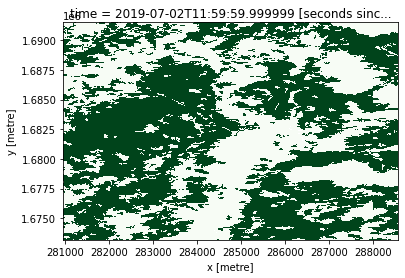

In [11]:
# Update the query as the crop-mask is only available for the year 2019.
query.update({'time' : '2019'})

# Now load the crop-mask using the query.
cm = dc.load(product='crop_mask',
             measurements=['filtered'],
             **query).filtered.squeeze()

cm.where(cm<255).plot.imshow(cmap='Greens', add_colorbar=False); # we filter to <255 to omit missing data

In [12]:
# Filter out the no data (255) and non-crop (0) pixels from the crop-mask `filtered` band and
# mask the data.
data = data.where(cm == 1)

In [13]:
%%time
data = data.compute()

CPU times: user 506 ms, sys: 190 ms, total: 696 ms
Wall time: 2.66 s


## Classification using K-means Clustering

### Run Standard Scaler for all parameters

In [14]:
# Use the `sklearn_flatten` function to convert the `data` xarray.Dataset into a 2 dimensional numpy array.
model_input = sklearn_flatten(data)

In [15]:
%%time
# Standardize the model_input (numpy array) by removing the mean and scaling to unit variance.
scaler = StandardScaler()
scaler.fit(model_input)
model_input = scaler.transform(model_input)

CPU times: user 103 ms, sys: 25.3 ms, total: 128 ms
Wall time: 126 ms


In [16]:
# Check for np.nan values in the scaled dataset.
np.unique(np.isnan(model_input))

array([False])

### Run K-Means Clustering

Perform k-means clustering on the standardized `model_input` numpy array. 

In [17]:
%%time
# Set up the kmeans classification by specifying the number of clusters
kmeans = KMeans(n_clusters=no_of_clusters, random_state=42)

# Perform Kmeans clustering on the 'model_input'.
# Begin iteratively computing the position of the clusters.
kmeans.fit(model_input)

# Use the sklearn kmeans `.predict` method to assign all the pixels of the `model_input` to a unique cluster.
flat_predicted = kmeans.predict(model_input)

# Use the sklearn_unflatten function to convert the flat predictions into a xarray DataArray.
predicted = sklearn_unflatten(flat_predicted, data)
predicted = predicted.transpose("y", "x")

CPU times: user 4min 23s, sys: 15.2 s, total: 4min 38s
Wall time: 19.1 s


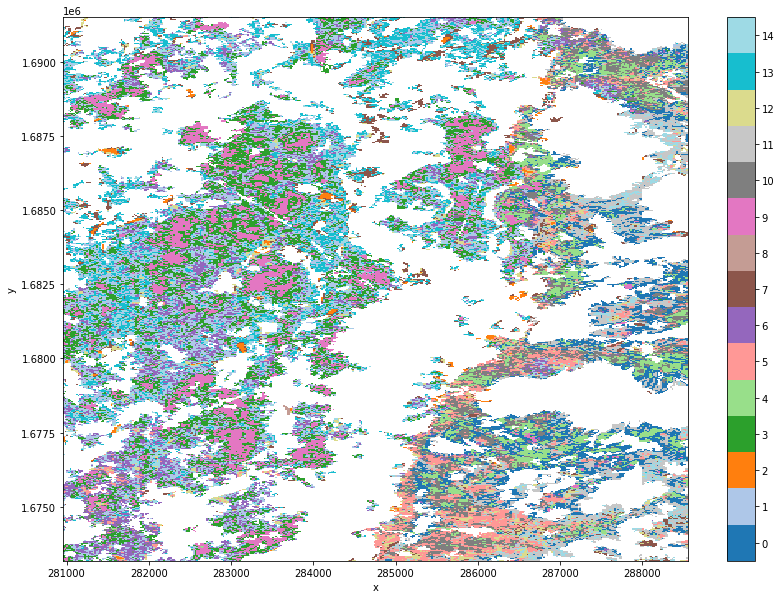

In [18]:
# Plot the predicted results.
cmap = plt.cm.get_cmap("tab20", no_of_clusters)
bounds = np.arange(- 0.5, no_of_clusters, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(14,10))
im = predicted.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False, ax=ax)
cbar=plt.colorbar(im);
cbar.set_ticks(range(no_of_clusters))
# Save the plot.
plt.savefig(f"{output_dir}/{file_name}_kmeans_{no_of_clusters}classes_predicted_{time_01}.png")

## Pickle the resulting data for the next notebook

In [19]:
# Pickle the K-Means clustering prediction results for use in the next notebook.
pickled_prediction = (
    f"{output_dir}/{file_name}_kmeans_{no_of_clusters}classes_predicted_{time_01}.pickle"
)

# Format data for pickle.
pickle_data = (
    predicted.x.to_numpy(),  # x-values
    predicted.y.to_numpy(),  # y-values
    predicted.to_numpy(),  # k-means prediction values
    data.crs,  # coordinate reference system
)

with open(pickled_prediction, "wb") as f:
    pickle.dump(pickle_data, f)

## Recommended next steps

To continue working through the notebooks in this workflow, go to the next notebook `02_group_classes_using_NDVI.ipynb`.

1. **Unsupervised Class Identification (this notebook)**
2. [Group Classes Using NDVI](02_group_classes_using_NDVI.ipynb.ipynb)
3. [Reclassify Unsupervised NDVI](03_reclassify_unsupervised_map_NDVI_classes.ipynb)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [20]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [21]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2022-06-23'

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
